# Demo of the functions presented in the Github Repo

Please note that there are some additional files needed to run these effectively in addition to the data, which I cannot share as I am not the owner of it. If you have access to the data, please contact me, and I will share the files (excel/csv files) to run the code properly. 

In [1]:
# Import necessary libraries
import tdt
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPy

from collections import defaultdict

from multi_unit_functions import *
from multi_unit_plotting_functions import *
from GP_functions import *

%matplotlib inline

In [2]:
# Opening files and paths
root_dir = os.getcwd()
matching_path = 'BackupStimoFiles/Lists_matching_blocks.xlsx'
bltime=700 # baseline duration (ms)
wtime=150  # response duration (ms)

# Block 3, M1 Stims
block_path = "sBuck_200105/Block-3"
block_number = int(block_path.split('-')[1])

## Get Stimulation information
data, stimulation_data = load_block_stim_data(block_number, block_path, verbose=False)

## Get MUA activity estimation (threshold crossing rates)
stream = data.streams.Wave
df_M1 = MUA_stream_extract(stream, stimulation_data, wtime=wtime,baseline_time=bltime, verbose=False)

# Mapping electrodes to the channels
df_M1 = append_electrodes(df_M1, stream, block_number, verbose=False)

#---------------------
# Block 18, PMd stims
block_path = "sBuck_200105/Block-18"
block_number = int(block_path.split('-')[1])
data, stimulation_data = load_block_stim_data(block_number, block_path, verbose=False)
stream = data.streams.Wave
df_PMd = MUA_stream_extract(stream, stimulation_data, wtime=wtime, baseline_time=bltime, verbose=False)
df_PMd = append_electrodes(df_PMd, stream, block_number, verbose=False)

#--------------------------------------------------------
# Block 21, PMv stims
block_path = "sBuck_200105/Block-21"
block_number = int(block_path.split('-')[1])
data, stimulation_data = load_block_stim_data(block_number, block_path, verbose=False)
stream = data.streams.Wave
df_PMv = MUA_stream_extract(stream, stimulation_data, wtime=wtime, baseline_time=bltime, verbose=False)
df_PMv = append_electrodes(df_PMv, stream, block_number, verbose=False)
print('Data loaded')

read from t=0s to t=99.59s
read from t=0s to t=233.39s
read from t=0s to t=259.64s
Data loaded


## Creating heatmaps

This will demonstrate 2 concepts: 
- Mean heatmap (mean of all trials for a given stimulation channel)
- Individual heatmap (10 heatmaps after each trial)

The functions will default to taking the _delta rate_ as the column to fetch values from. This can be changed to any desired value, such as baseline crossing rates, band-power, etc. Just make sure that the column is defined before

In [3]:
# Create the heatmaps
M1_mean, M1_heatmaps = get_online_heatmaps(df_M1) 
PMv_mean, PMv_heatmaps = get_online_heatmaps(df_PMv)
PMd_mean, PMd_heatmaps = get_online_heatmaps(df_PMd)

## Visualizing heatmaps

In general, it is easiest to do it as the following but there are many more options available in the plotting functions, please read the description of each functions for more details. 

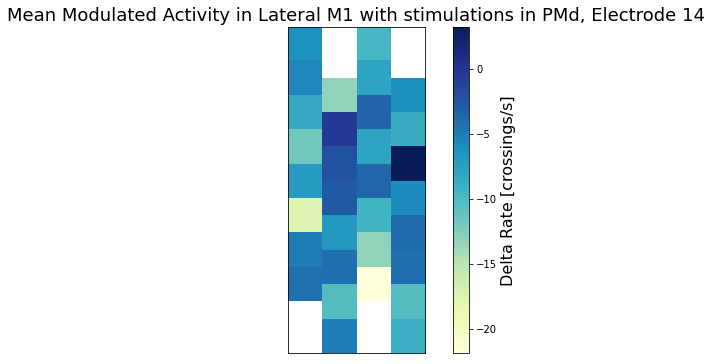

In [4]:
# Plotting the mean of all trials
electrode = 14
title = 'Mean Modulated Activity in Lateral M1 with stimulations in PMd, Electrode {}'.format(electrode)

fig, ax = plt.subplots(figsize=(10,6))

# Puts the values in the right orientation
spatial_map = plot_spatials(electrode_values = PMd_mean[electrode]) 

# This actually plots it
im = ax.imshow(spatial_map, cmap = 'YlGnBu', vmin=np.nanmin(spatial_map), vmax=np.nanmax(spatial_map))

# Making the plot look better
ax.set_title(title, fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
cbar = fig.colorbar(im) 
cbar.set_label('Delta Rate [crossings/s]',size=16)

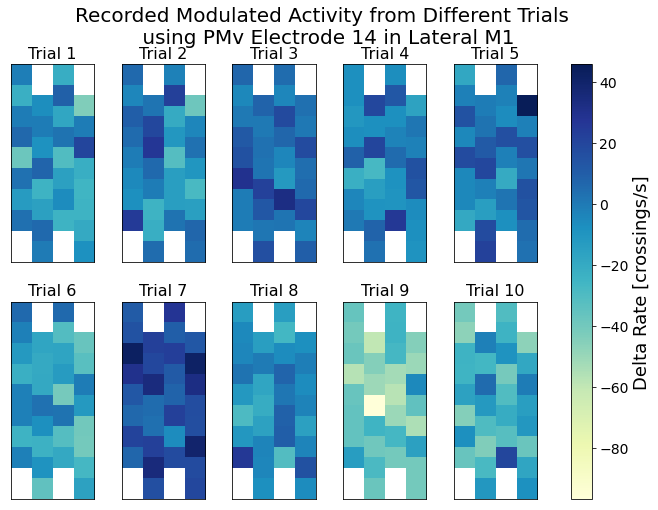

In [5]:
# Plotting all trials for a given electrode
title = 'Recorded Modulated Activity from Different Trials \n using PMv Electrode {} in Lateral M1'.format(electrode) 

# Looping variables
a = np.arange(10).reshape(2, 5)
trial_values = [np.empty((1, 32)) for x in range(10)]

# # Get the data to plot
mean_values =PMv_heatmaps[1][electrode].values
for i in range(10):
    trial_values[i] = PMv_heatmaps[i][electrode].values
    
# Colour bar values
cbar_min = np.nanmin((np.vstack((mean_values, trial_values))))
cbar_max = np.nanmax((np.vstack((mean_values, trial_values))))    

# Plot the different trials
fig, ax = plt.subplots(2, 5, figsize=(12,8))
for i in range(2):
    for j in range(5):
        spat_map = plot_spatials(electrode_values = trial_values[a[i, j]])
        im = ax[i, j].imshow(spat_map, cmap='YlGnBu', vmin=cbar_min, vmax = cbar_max)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title('Trial {}'.format(a[i,j]+1), fontsize=16)
     
        
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), location='right')
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Delta Rate [crossings/s]', size=18)
fig.suptitle(title, fontsize=20);

There is a function called `plot_individual_trials` in `multi_unit_plotting_functions.py` that will create both of these plots, but does not provide as much flexibility into adjusting plot parameters (text size, figure size, e.g.)

## Visualizing larger heatmaps

Above, I plot what happens when you plot the activity when stimulating from one individual electrode. For a higher level viewing of what happens in all electrodes, it is possible to plot the entire heatmap. Any given column of this high-level heatmap will give the values needed to make plots like the ones above. 

Moreover, rows of this high-level heatmap will summarize the activity of one recording electrode for all stimulation electrodes in the stimulation array. This can be used to view how the stimulation site affects indiviual recording areas. (Before it is the opposite, how does one stimulation site affect activity seen by the entire recording array)

By default it will sort by column and row mean, such that excitatory stimualtions tend to the right and excitatory recordings tend to the top.

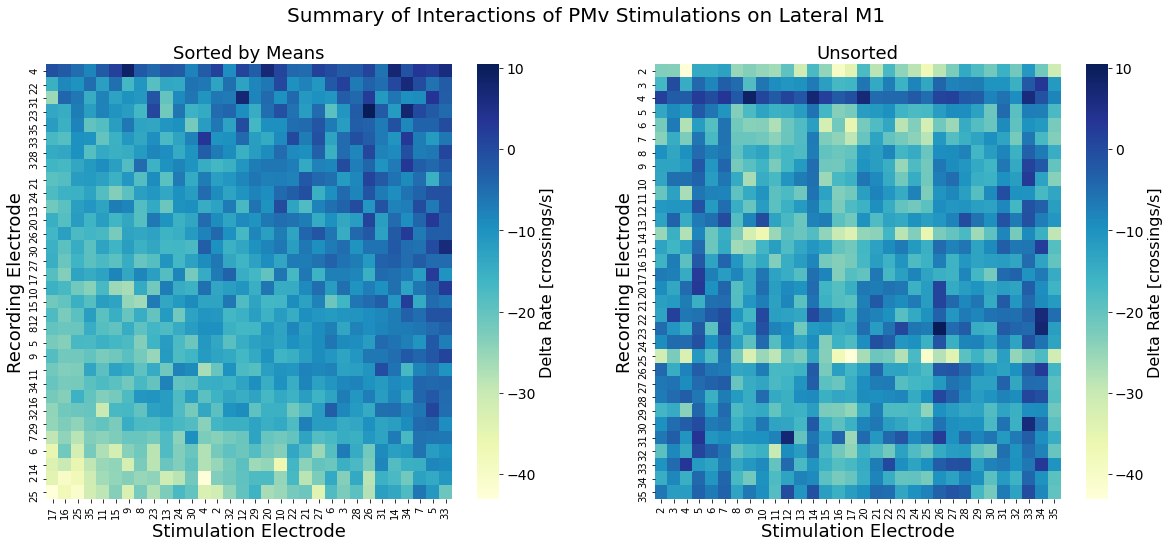

In [6]:
# Plot the Larger heatmap
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.heatmap(get_delta_heatmap(df_PMv), cmap ='YlGnBu', ax=ax[0]) # This plots it
sns.heatmap(get_delta_heatmap(df_PMv, sort=False), cmap ='YlGnBu', ax=ax[1])


# Adjusting the color bars
for i in range(len(ax)):
    cbar = ax[i].collections[0].colorbar
    cbar.set_label('Delta Rate [crossings/s]', size=16)
    cbar.ax.tick_params(labelsize=14)

# Adjusting the plots
for i in range(len(ax)):
    ax[i].set_xlabel('Stimulation Electrode', size=18)
    ax[i].set_ylabel('Recording Electrode', size=18)
ax[0].set_title('Sorted by Means', size=18)
ax[1].set_title('Unsorted', size=18)
fig.suptitle('Summary of Interactions of PMv Stimulations on Lateral M1', size=20);

## Parallel GP-BO

This next portion will show how to use the parallel GP-BO code that I've written. It will include how to prepare the data to use and how to run the GP-BO. 

Please refer to my master thesis to understand the different tuneable parameters)

In [28]:
# Generate the objective function
target_electrode = 79
target = M1_heatmaps[1][target_electrode].values

# Get the ground truth values
X, Y_pmd, Y_pmv = get_2d_data(PMd_heatmaps[1], PMv_heatmaps[1], target, normalize=False, clipping=False)

# # Generate synthetic data
X, Ysyn_PMd, Ysyn_PMv = generate_synthetic_data(PMd_heatmaps[1], PMv_heatmaps[1], target, stdev=4, normalize=True, clipping=True)

### The GP Fit on Synthetic Data

In [31]:
# Variables to store results
locations = []
xs = []; ys=[]

# Hyperparameter values
epsilon=0.1
alpha=2
constraint=[1,1]
n_queries=5

# Kernels
k_pmd = GPy.kern.RBF(input_dim=2, ARD=True)
k_pmv = GPy.kern.RBF(input_dim=2, ARD=True)

# Set initial random points
for i in range(n_queries):
    locations.append('PMd')
xs_pmd, ys_pmd = build_random_search(X, Ysyn_PMd[np.random.choice(10)],n_queries)
m_pmd = fit_GP(k_pmd, xs_pmd, ys_pmd, constraint)

for i in range(n_queries):
    locations.append('PMv')
xs_pmv, ys_pmv = build_random_search(X, Ysyn_PMv[np.random.choice(10)],n_queries)
m_pmv = fit_GP(k_pmv, xs_pmv, ys_pmv, constraint)

# Append the previous guesses
xs = np.append(xs, (xs_pmd, xs_pmv)).reshape(-1, 2)
ys = np.append(ys, (ys_pmd, ys_pmv)).reshape(-1, 1)


# Random search
xrand1, yrand1 = build_random_search(X, Y_pmd, len(Y_pmd))
loc1 = np.array(['PMd' for i in range(len(Y_pmd))])
rand_pmd = np.array(list(zip(xrand1, yrand1, loc1)))

xrand2, yrand2= build_random_search(X, Y_pmv, len(Y_pmv))
loc2 = np.array(['PMv' for i in range(len(Y_pmv))])
rand_pmv = np.array(list(zip(xrand2, yrand2, loc2)))

rand_search = np.vstack((rand_pmd, rand_pmv))
np.random.shuffle(rand_search)

# The GPBO
for i in range(54):
    xs, ys, locations = append_next_query(X, Ysyn_PMd[np.random.choice(10)], Ysyn_PMv[np.random.choice(10)], xs, ys, locations, m_pmv, m_pmd, alpha=alpha, epsilon=epsilon)
    
    # Refit the models
    # Get the indices where each location has been queried
    pmd_idx = np.where(locations == 'PMd')
    pmv_idx = np.where(locations == 'PMv')
    # Refit
    m_pmd = fit_GP(k_pmd, xs[pmd_idx], ys[pmd_idx], constraint)
    m_pmv = fit_GP(k_pmv, xs[pmv_idx], ys[pmv_idx], constraint)
    
    # Epsilon decay
    if epsilon > 0.01:
        epsilon *= 0.99
        
    # Stop if querying the same place 3x in the same GP
    pmd_queries = xs[np.where(locations=='PMd')]
    pmv_queries = xs[np.where(locations=='PMv')]
    if str(pmd_queries[-1]) == str(pmd_queries[-2]) == str(pmd_queries[-3]) or \
       str(pmv_queries[-1]) == str(pmv_queries[-2]) == str(pmv_queries[-3]):
        break

for i, (a, b) in (list(enumerate(zip(xs, locations)))):
    print(i, a, b)

0 [1. 3.] PMd
1 [2. 5.] PMd
2 [1. 0.] PMd
3 [0. 2.] PMd
4 [3. 2.] PMd
5 [2. 1.] PMv
6 [0. 7.] PMv
7 [0. 6.] PMv
8 [0. 3.] PMv
9 [1. 0.] PMv
10 [2. 1.] PMd
11 [2. 3.] PMd
12 [1. 1.] PMv
13 [2. 2.] PMd
14 [2. 0.] PMd
15 [2. 0.] PMv
16 [1. 4.] PMd
17 [2. 1.] PMv
18 [3. 1.] PMd
19 [3. 3.] PMd
20 [1. 1.] PMd
21 [2. 1.] PMv
22 [1. 0.] PMd
23 [3. 5.] PMd
24 [2. 1.] PMd
25 [2. 1.] PMd
26 [2. 1.] PMd


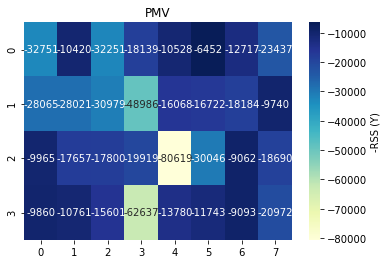

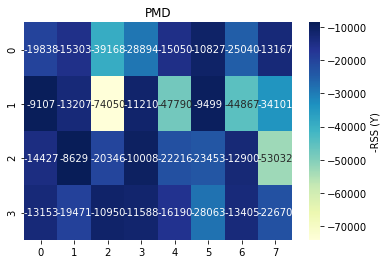

In [32]:
# "Ground truth" maps 
plt.close('all')
plt.figure(figsize=(6,4))
plt.title('PMV')
sns.heatmap(np.flip(Y_pmv.reshape(-4, 8)), cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': '-RSS (Y)'})

plt.figure(figsize=(6, 4))
plt.title('PMD')
sns.heatmap(np.flip(Y_pmd.reshape(-4, 8)), cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': '-RSS (Y)'})

In this example,the parallel GP-BO converged to the best electrode in 26 queries

### The GP Fit on Meaned Data

In [33]:
# Generate the objective function
target_electrode = 79
target = M1_mean[target_electrode].values

# Get the ground truth values
X, Y_pmd, Y_pmv = get_2d_data(PMd_mean, PMv_mean, target, normalize=False, clipping=False)

In [34]:
# Variables to store results
locations = []
xs = ys=[]


k_pmd = GPy.kern.RBF(input_dim=2, ARD=True)
k_pmv = GPy.kern.RBF(input_dim=2, ARD=True)
# k_pmd = GPy.kern.Matern52(input_dim=2, ARD=True)
# k_pmv = GPy.kern.Matern52(input_dim=2, ARD=True)
constraints = [1, 1]
alpha=6e-4
epsilon=0.1

# Force a random first guess in each area
n_queries=5
for i in range(n_queries):
    locations.append('PMd')
xs1, ys1 = build_random_search(X, Y_pmd, n_queries)
m_pmd = fit_GP(k_pmd, xs1, ys1, constraints, )


for i in range(n_queries):
    locations.append('PMv')
xs2, ys2 = build_random_search(X, Y_pmv, n_queries)
m_pmv = fit_GP(k_pmv, xs2, ys2, constraints)


# Append the next guesses
xs = np.append(xs,(xs1, xs2)).reshape(-1, 2)
ys = np.append(ys, (ys1, ys2)).reshape(-1, 1)

for i in range(57):
    xs, ys, locations = append_next_query(X, Y_pmd, Y_pmv, xs, ys, locations, m_pmv, m_pmd, alpha=alpha, epsilon=epsilon)
    
    
    ## Refit the models
    # Get indices where each location has been queried
    pmd_idx = np.where(locations == 'PMd')
    pmv_idx = np.where(locations == 'PMv')
    # Refit
    m_pmd = fit_GP(k_pmd, xs[pmd_idx], ys[pmd_idx], constraints, )
    m_pmv = fit_GP(k_pmv, xs[pmv_idx], ys[pmv_idx], constraints, )

    if epsilon >0.01:
#         epsilon -=(0.01)
        epsilon *=0.99
    
    # Stop if querying the same place 3x in the same GP
    pmd_queries = xs[np.where(locations=='PMd')]
    pmv_queries = xs[np.where(locations=='PMv')]
    if str(pmd_queries[-1]) == str(pmd_queries[-2]) == str(pmd_queries[-3]) or \
       str(pmv_queries[-1]) == str(pmv_queries[-2]) == str(pmv_queries[-3]):
        break

for i, (a, b) in (list(enumerate(zip(xs, locations)))):
    print(i, a, b)
print('pmv')
# print(m_pmv.rbf.lengthscale)
print('pmd')
# print(m_pmd.rbf.lengthscale)
print('Best electrode value {}'.format(np.max((Y_pmd, Y_pmv))))
if np.argmax((Y_pmd, Y_pmv)) <32:
    print('Located in PMd')
else:
    print('Located in Pmv')
print('Final Epsilon {:.5f}'.format(epsilon))

 C:\Users\Julien\anaconda3\envs\thesis\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


0 [3. 2.] PMd
1 [3. 0.] PMd
2 [1. 6.] PMd
3 [2. 6.] PMd
4 [3. 5.] PMd
5 [0. 4.] PMv
6 [1. 6.] PMv
7 [3. 1.] PMv
8 [1. 1.] PMv
9 [3. 6.] PMv
10 [0. 3.] PMd
11 [3. 7.] PMd
12 [3. 4.] PMd
13 [3. 1.] PMd
14 [0. 4.] PMd
15 [3. 3.] PMd
16 [0. 1.] PMd
17 [0. 5.] PMd
18 [0. 7.] PMd
19 [0. 0.] PMd
20 [0. 2.] PMd
21 [3. 4.] PMv
22 [1. 4.] PMd
23 [0. 6.] PMd
24 [0. 0.] PMv
25 [1. 3.] PMv
26 [0. 7.] PMv
27 [0. 5.] PMv
28 [2. 7.] PMv
29 [1. 1.] PMd
30 [1. 5.] PMd
31 [2. 5.] PMv
32 [3. 3.] PMv
33 [1. 7.] PMd
34 [1. 3.] PMd
35 [0. 2.] PMv
36 [0. 3.] PMv
37 [3. 2.] PMv
38 [3. 0.] PMv
39 [2. 4.] PMv
40 [1. 2.] PMv
41 [0. 1.] PMv
42 [0. 6.] PMv
43 [3. 5.] PMv
44 [0. 4.] PMd
45 [0. 4.] PMd
46 [0. 4.] PMd
pmv
pmd
Best electrode value -699.5646258503402
Located in PMd
Final Epsilon 0.06894


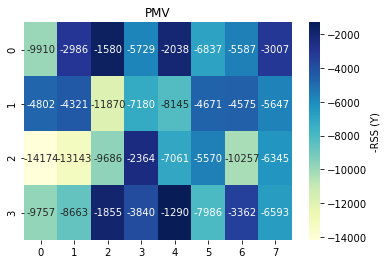

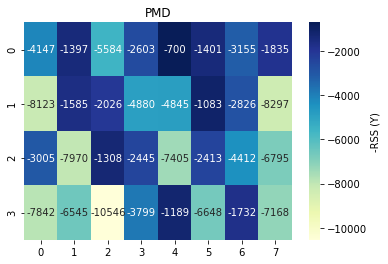

In [35]:
# "Ground truth" maps 
plt.close('all')
plt.figure(figsize=(6,4))
plt.title('PMV')
sns.heatmap(np.flip(Y_pmv.reshape(-4, 8)), cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': '-RSS (Y)'})

plt.figure(figsize=(6, 4))
plt.title('PMD')
sns.heatmap(np.flip(Y_pmd.reshape(-4, 8)), cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': '-RSS (Y)'})

In this example, the parallel GP-BO also converged to the best electrode again. 